# Guessed Artist!

Un proyecto sencillo para la clasificación de obras de arte usando Deep Learning 

> **NOTA:** Este notebook retoma el trabajo en el notebook **guessed-style** obteniendo un 1% de acierto más, y añadiendo predicción para imágenes individuales, con ejemplos (el otro notebook se conserva por mantener los resultados que se publicaron en un artículo). Para la clasificación por autor, consultar el notebook **guessed-artist**.

## Introducción

### Motivación

Hace unos meses tuve la suerte de visitar una [exposición](https://www.museothyssen.org/exposiciones/monetboudin) conjunta sobre [Claude Monet](https://www.wikiart.org/es/claude-monet) y [Eugène Boudin](https://www.wikiart.org/es/eugene-boudin). El primero, máximo exponente del *Impresionismo*, es uno de mis pintores favoritos (incluso le copié algún cuadro cuando era un chaval); pero sorprendentemente no conocía nada del segundo. Resulta que Monet fue *discípulo* de Boudin (empezó a pintar gracias a él), aunque acabó eclipsando totalmente a su maestro. Ambos mantuvieron una larga relación de amistad, desencuentros, y admiración mutua por encima de todo. 

En la exposición se podía comprobar la evolución de los dos pintores, desde un mismo punto de partida y misma temática, pero siguiendo distintos caminos, que con el tiempo volvieron a entrecruzarse. Resultado: una visita de casi 1 hora donde lo primero que hacías al ponerte delante de un nuevo cuadro era intentar adivinar su autor. ¡Pero no era nada sencillo!

Revisando la aplicación de redes neuronales convolucionales al reconocimiento de imágenes me vino a la cabeza aquella exposición. ¿Cómo de difícil resultaría para estas redes la tarea de distinguir el autor de un cuadro? ¿Será mucho más complicado que distinguir animales en fotografías? Vamos a comprobarlo :)

### Los datos

Para poder entrenar a nuestra red neuronal necesitaremos las fotos de muchos cuadros. Por suerte contamos con un dataset de obras de arte recopilado de [WikiArt](http://www.wikiart.org/) para una [competición de Kaggle](https://www.kaggle.com/c/painter-by-numbers/overview). Las imágenes de este dataset tienen copyright, pero se permite su uso para la minería de datos. Cuenta con algo más de 100.000 pertenecientes a 2.300 artistas, cubriendo un montón de estilos y épocas. Cada imagen está etiquetada en un fichero csv que obtendremos aparte. 

**NOTA**: Por rendimiento usaremos una versión preprocesada del dataset, con imágenes más pequeñas obtenidas de [aquí](https://www.kaggle.com/c/painter-by-numbers/discussion/23099).

### Las herramientas

Para este pequeño proyecto vamos a utilizar la librería [fastai](https://docs.fast.ai/), que corre sobre [PyTorch](https://pytorch.org/). Fastai simplifica el entrenamiento de redes neuronales aplicando técnicas punteras de forma eficiente, y obteniendo resultados a la altura de los últimos avances en visión artificial, procesamiento del lenguaje natural, datos tabulares y filtrado colaborativo.

## Manos a la obra

### Inicializaciones

Dependiendo del entorno realizamos una inicialización previa:

In [0]:
%%capture
from notebook import notebookapp
server = list(notebookapp.list_running_servers())[0]

if server['hostname'] == 'localhost':
  # Local environment
  %reload_ext autoreload
  %autoreload 2
  %matplotlib inline
else:
  # Cloud
  !pip install git+https://github.com/fastai/fastai.git
  !curl https://course.fast.ai/setup/colab | bash

Hacemos los imports necesarios (el uso del asterisco no está recomendado pero es útil a la hora de probar una nueva librería).

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.utils.show_install import *
from shutil import copy, move

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import pandas as pd
import numpy as np
import os
import requests
import json

np.random.seed(42)

In [3]:
# Show info about the environment. Useful when you are in Colab 
# and you wanna know if you were assigned the best GPU ;)
show_install()



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.53.dev0
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-

### Obtención de los datos

Vamos a usar la versión *lite* del dataset original, que contiene todas las imágenes pero con un tamaño reducido, a sabiendas de que para entrenar nuestra red usaremos tamaños como 224x224 o 299x299 píxeles.

Las imágenes reducidas se encuentran en un [repositorio de github](https://github.com/zo7/painter-by-numbers/releases/), divididas entre un fichero comprimido con las imágenes de entrenamiento y otro con las de test. Descargaremos ambos, los descomprimiremos, y copiaremos todas las imágenes a una misma ubicación.

In [4]:
train_dir = untar_data('https://github.com/zo7/painter-by-numbers/releases/download/data-v1.0/train')
train_dir, len(train_dir.ls())

(PosixPath('/root/.fastai/data/train'), 79433)

In [0]:
base_dir = train_dir.parent
pictures_dir = base_dir/'pictures'
pictures_dir.mkdir(exist_ok=True)

In [6]:
for f in train_dir.ls():
    copy(f, pictures_dir)
len(pictures_dir.ls())

79433

In [7]:
test_dir = untar_data('https://github.com/zo7/painter-by-numbers/releases/download/data-v1.0/test')
test_dir, len(test_dir.ls())

(PosixPath('/root/.fastai/data/test'), 23817)

In [8]:
for f in test_dir.ls():
    copy(f, pictures_dir)
len(pictures_dir.ls())

103250

Este es el número exacto de cuadros incluidos en nuestro dataset.

A continuación descargamos el fichero CSV con toda la información asociada a las imágenes (autor, estilo, género, nombre del fichero, etc). El fichero está alojado en mi repositorio de github por sencillez, pero se obtuvo previamente de [Kaggle](https://www.kaggle.com/c/painter-by-numbers/data):

In [0]:
zip_url = 'https://github.com/pyjaime/guessed-artist/raw/master/data/all_data_info.csv.zip'
with urlopen(zip_url) as zip_res:
    with ZipFile(BytesIO(zip_res.read())) as zfile:
        zfile.extractall(base_dir)

Cargamos la información del CSV en un dataframe de Pandas:

In [0]:
csv = base_dir/'all_data_info.csv'
df = pd.read_csv(csv, low_memory=False)

Vemos qué tipo de datos contiene de forma rápida:

In [11]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


## Clasificación por estilo (v2)

Lo primero que vamos a tratar de hacer con los datos, a modo de *entrenamiento* y por curiosidad, es crear un modelo para clasificar los cuadros **por estilo**. A priori contamos con dicha información en la columna `style`. Veamos qué contiene exactamente.

### Preprocessing

La columna `style` cuenta con un montón de categorías diferentes que en algunos casos parecen incluso una broma:

In [12]:
style_counts = df['style'].value_counts()
print(len(style_counts), style_counts.keys())

136 Index(['Impressionism', 'Realism', 'Romanticism', 'Expressionism',
       'Post-Impressionism', 'Art Nouveau (Modern)', 'Baroque', 'Surrealism',
       'Symbolism', 'Rococo',
       ...
       'Synchromism', 'Nas-Taliq', 'Miserablism', 'Perceptism ', 'Rayonism',
       'Spectralism', 'Kinetic Art', 'Ilkhanid', 'Environmental (Land) Art',
       'Renaissance'],
      dtype='object', length=136)


Nosotros usaremos sólo los estilos más repetidos en el dataset; ya que en mi opinión las categorías están demasiado atomizadas (de hecho yo sería aún más selectivo).

**NOTA:** En esta segunda versión cogeremos 25 estilos en lugar de 16, y usaremos 750 muestras de cada uno.

In [13]:
style_labels = style_counts[style_counts > 750].keys().to_list()
len(style_labels)

25

Vemos la lista de estilos íntegra, junto al número de obras en cada uno de ellos (más que suficiente):

In [14]:
df.groupby('style')['size_bytes'] \
        .aggregate(['count']) \
        .sort_values(by=['count'], ascending=False).query('count > 750')

,count
style,
Impressionism,10643
Realism,10523
Romanticism,9285
Expressionism,7013
Post-Impressionism,5778
Art Nouveau (Modern),4899
Baroque,4400
Surrealism,4167
Symbolism,3476


In [0]:
# Uncomment this if you want to use a specific list of styles
#style_labels = ['Pointillism', 'Cubism']

Creamos un nuevo dataframe usando sólo los estilos seleccionados:

In [16]:
df_styles = df.query('style in @style_labels')
len(df_styles)

84804

Para que el dataset esté balanceado y el procesamiento sea más rápido, hacemos un muestro para quedarnos con el mismo número de imágenes por estilo:

In [0]:
sample_size = 750

In [18]:
df_styles = df_styles.groupby('style')['style','new_filename'].apply(lambda s: s.sample(sample_size))
len(df_styles)

18750

In [19]:
df_styles.tail()

style new_filename
style                              
Ukiyo-e 10834  Ukiyo-e     9768.jpg
        10488  Ukiyo-e    68164.jpg
        13857  Ukiyo-e    63310.jpg
        5400   Ukiyo-e    47431.jpg
        76012  Ukiyo-e     1229.jpg

Aquí es donde entra en juego la librería **fastai**. Con una única línea de código conseguiremos:
* crear los subconjuntos de entrenamiento y validación a partir del dataframe anterior, usando la estructura de Imagenet.
* asignar una serie de [transformaciones](https://docs.fast.ai/vision.transform.html#get_transforms) aleatorias para las imágenes (`ds_tfms`), que funcionan bastante bien en muchos escenarios. *(Ver párrafo siguiente)*.
* configurar el tamaño de las imágenes a enchufar a nuestra red (`size`).
* asignar el tamaño del batch (`bs`) para entrenamiento
* aplicar normalización; algo deseable cuando vamos a usar una red neuronal (`normalize()`).

El *aumento de datos* (**data augmentation**) es posiblemente la técnica de regularización más importante cuando se entrena un modelo para reconocimiento de imágenes. En lugar de alimentar nuestra red con las mismas imágenes una y otra vez, hacemos pequeñas transformaciones aleatorias (un poco de rotación, traslación, zoom, etc.) que no cambie lo que está dentro de la imagen a simple vista, pero sí que cambie los valores de sus píxeles. Los modelos entrenados con esta técnica generalizarán mejor. En nuestro caso igual puede tener menos sentido que en otros escenarios, ya que los cuadros *no se mueven*. Pero si pensamos en la posibilidad de poner nuestro modelo en producción, donde cualquiera pudiera enviar una imagen hecha con el móvil, seguro que vamos a querer aplicar esta técnica.

In [20]:
data = ImageDataBunch.from_df(df=df_styles, path=pictures_dir, 
                              label_col='style', fn_col='new_filename',
                              ds_tfms=get_transforms(), size=299, bs=48
                              ).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (15000 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Abstract Art,Abstract Art,Abstract Art,Abstract Art,Abstract Art
Path: /root/.fastai/data/pictures;

Valid: LabelList (3750 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Art Nouveau (Modern),Art Informel,Academicism,Romanticism,Abstract Expressionism
Path: /root/.fastai/data/pictures;

Test: None

Vemos una pequeña muestra de los datos, con su etiqueta correspondiente:

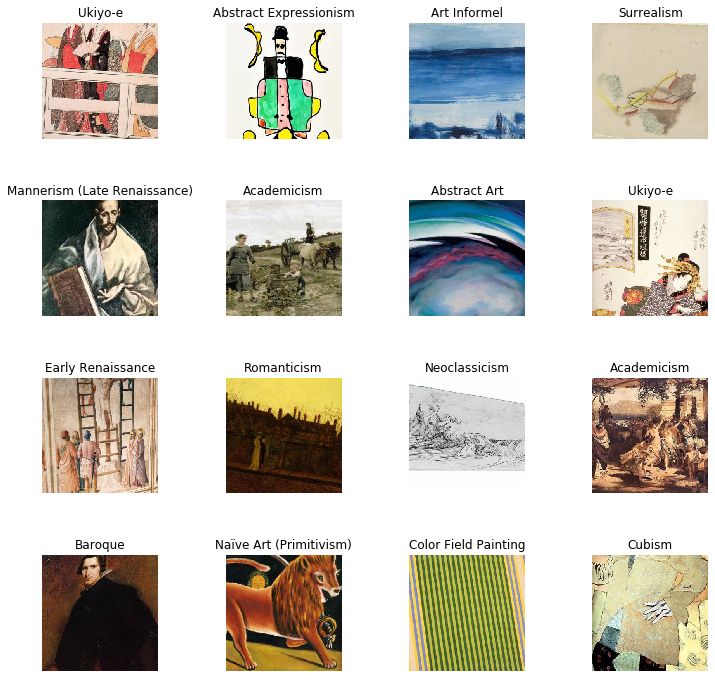

In [21]:
data.show_batch(rows=4, figsize=(10,10))

### Training: resnet-50

Para llevar a cabo nuestra tarea, necesitamos elegir primero el tipo de red neuronal, y la arquitectura subyacente.

Nos basaremos en una red neuronal convolucional (**CNN**), debido a su rendimiento contrastado en clasificación de imágenes. Para la arquitectura no partiremos de cero, sino que usaremos un modelo pre-entrenado sobre ImageNet (un dataset con más de 1 millón de imágenes), que ya sabe reconocer muchas cosas. Más concretamente usaremos **ResNet-34** y **ResNet-50** (el nº hace referencia a las capas). Por tanto, estaremos aplicando lo aprendido con ImageNet a nuestra red (**Transfer Learning**), y la empezaremos a entrenar con las imágenes de pinturas, para obtener unos resultados a la altura del estado del arte, nunca mejor dicho.

Para llevar a cabo el entrenamiento en **fastai** sólo tendremos que ejecutar unas líneas. Primero instanciaremos un `Learner` especializado en CNN, especificando la arquitectura base. En este apartado usaremos directamente ResNet-50:

In [22]:
learner = cnn_learner(data, models.resnet50, metrics=[error_rate])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 48955087.99it/s]


A continuación usaremos la función `fit_one_cycle()` del Learner, para llevar a cabo el entrenamiento de nuestro modelo usando un algoritmo rapidísimo para arquitecturas complejas ([más](https://sgugger.github.io/the-1cycle-policy.html) sobre **1cycle**). El parámetro principal es el número de *epochs* a ejecutar:

In [23]:
learner.fit_one_cycle(6, callbacks=[callbacks.SaveModelCallback(learner, every='improvement', mode='min',
                                                      monitor='error_rate', name='style-r50-stage-1')])

epoch,train_loss,valid_loss,error_rate,time
0,2.300439,1.914173,0.603733,08:21
1,2.001451,1.752479,0.564267,07:59
2,1.847679,1.650396,0.536000,08:00
3,1.657176,1.540547,0.501333,08:00
4,1.529194,1.485027,0.485067,08:00
5,1.435923,1.480115,0.487200,07:59


Better model found at epoch 0 with error_rate value: 0.6037333607673645.
Better model found at epoch 1 with error_rate value: 0.5642666816711426.
Better model found at epoch 2 with error_rate value: 0.5360000133514404.
Better model found at epoch 3 with error_rate value: 0.5013333559036255.
Better model found at epoch 4 with error_rate value: 0.48506665229797363.


Entrenando el modelo simplemente modificando las capas adicionales conseguimos un acierto del 54,19%. Pero esto es sólo la fase 1; vamos a por la segunda.

In [0]:
learner.load('style-r50-stage-1') # uncomment this if you want the best model
#learner.save('style-r50-stage-1') # uncomment this if you want the last model

Intentamos encontrar cuál es la tasa de aprendizaje para la siguiente fase:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


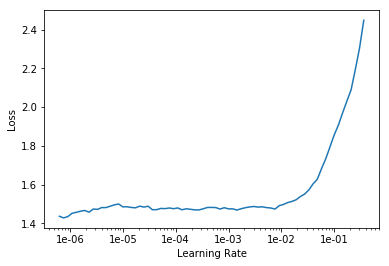

In [27]:
learner.lr_find()
learner.recorder.plot()

La idea en esta segunda fase es *descongelar* los pesos de las capas pertenecientes a la arquitectura de partida, para volver a entrenar nuestro modelo completo. De esta forma podremos mejorar un poco más nuestro clasificador.

La clave está en elegir la tasa de aprendizaje máxima para las distintas capas del modelo. Con esta gráfica elegiremos basicamente la tasa máxima para las primeras capas (una tasa pequeña, ya que dichas capas no necesitan mucho ajuste). La tasa máxima para las últimas capas se suele elegir unas 10 veces menor que la elegida para la primera fase (*3e-3* por defecto), teniendo en cuenta que nunca empeore el coste en la gráfica.

Descongelamos los pesos y volvemos a entrenar el modelo:

In [28]:
#learner.load('style-r50-stage-1')
learner.unfreeze()
learner.fit_one_cycle(7, max_lr=slice(8e-6,3e-4), 
                      callbacks=[callbacks.SaveModelCallback(learner, every='improvement', mode='min',
                                                      monitor='error_rate', name='style-r50-stage-2')])

epoch,train_loss,valid_loss,error_rate,time
0,1.456255,1.467102,0.479467,10:28
1,1.423300,1.428525,0.479200,10:24
2,1.270389,1.383087,0.448000,10:24
3,1.100680,1.348626,0.438667,10:22
4,0.905259,1.314179,0.429867,10:21
5,0.791067,1.313549,0.424267,10:21
6,0.722722,1.309049,0.420800,10:23


Better model found at epoch 0 with error_rate value: 0.47946667671203613.
Better model found at epoch 1 with error_rate value: 0.47920000553131104.
Better model found at epoch 2 with error_rate value: 0.4480000138282776.
Better model found at epoch 3 with error_rate value: 0.4386666715145111.
Better model found at epoch 4 with error_rate value: 0.4298666715621948.
Better model found at epoch 5 with error_rate value: 0.42426666617393494.
Better model found at epoch 6 with error_rate value: 0.42080000042915344.


Vemos cómo llega un momento en que el coste de validación deja de bajar. Nos quedaremos con el modelo en ese punto (*epoch 6*). El acierto de nuestro clasificador se queda en un **57,91%**, que no está mal si tenemos en cuenta la dificultad de la tarea. ¡Desde luego que a mí me supera!

In [0]:
learner.load('style-r50-stage-2');

### Results

Vamos a interpretar los resultados de forma rápida usando un par de herramientas básicas.

Primero pintamos las decisiones más fallidas de nuestro clasificador:

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()

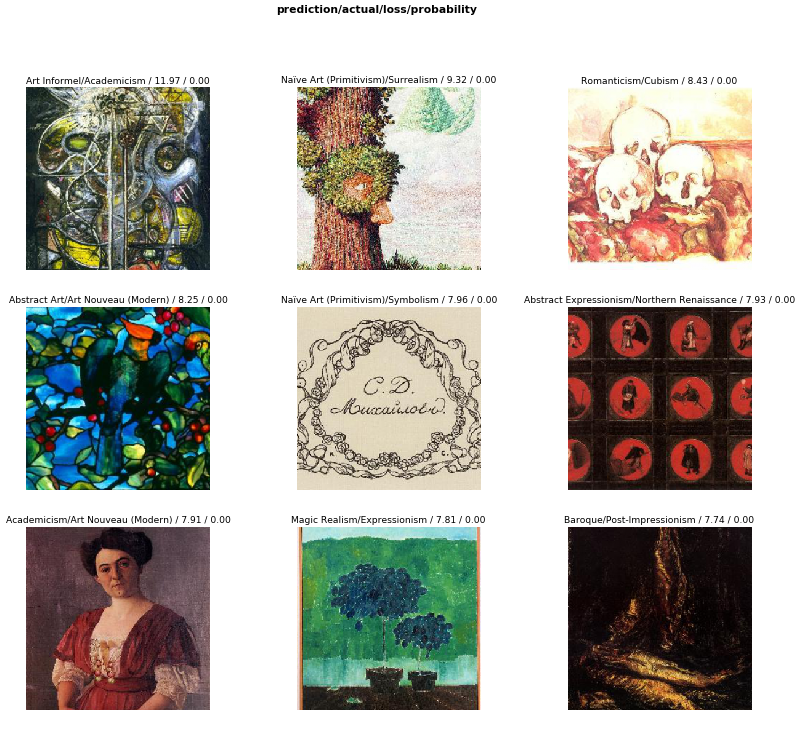

In [30]:
fig_top_losses = interp.plot_top_losses(9, heatmap=False, figsize=(18,15), return_fig=True)
fig_top_losses.dpi = 55

En estos ejemplos (el *bottom-9*) nuestro clasificador arrojó una probabilidad nula de que el estilo del cuadro fuera el que realmente es.

Pintamos la matriz de confusión para obtener una visión general de los errores:

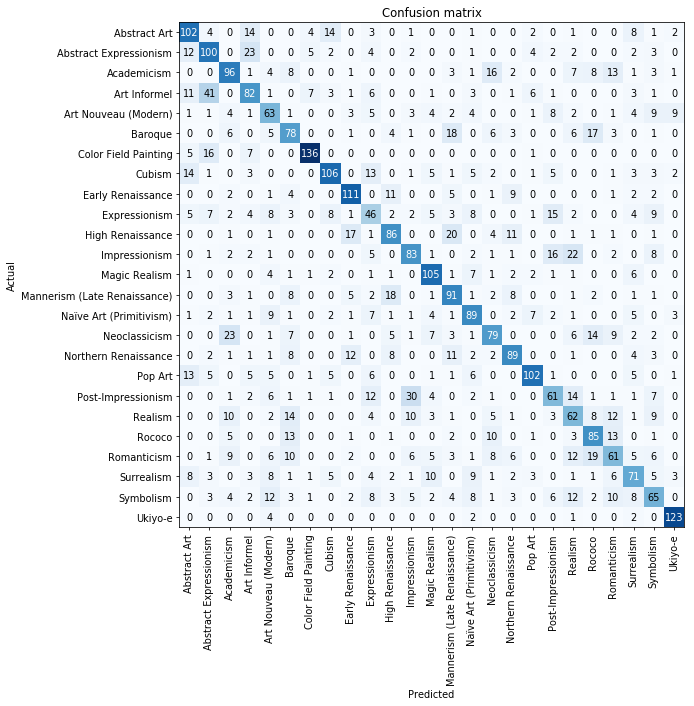

In [31]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=70)

Con esta gráfica podemos observar dónde se está equivocando nuestro clasificador exactamente. 

Existen varios estilos donde falla con mucha frecuencia. Así a primera vista no me extraña para nada su confusión entre:
* Expresionismo abstracto e Informalismo
* Neoclasicismo y Academicismo (¡para la Wikipedia son lo mismo!)
* Impresionismo, Post-Impresionismo y Expresionismo 
* Romanticismo y Realismo
* Barroco y Rococó
* Los distintos *estilos* dentro del Renacimiento

Es curioso, pero creo que coincido con la red neuronal en el estilo más sencillo de diferenciar: ¡el [Ukiyo-e](https://es.wikipedia.org/wiki/Ukiyo-e)!

Vamos a ver el ránking de categorías más equivocadas:

In [32]:
interp.most_confused(min_val=10)

[('Art Informel', 'Abstract Expressionism', 41),
 ('Post-Impressionism', 'Impressionism', 30),
 ('Abstract Expressionism', 'Art Informel', 23),
 ('Neoclassicism', 'Academicism', 23),
 ('Impressionism', 'Realism', 22),
 ('High Renaissance', 'Mannerism (Late Renaissance)', 20),
 ('Romanticism', 'Rococo', 19),
 ('Baroque', 'Mannerism (Late Renaissance)', 18),
 ('Mannerism (Late Renaissance)', 'High Renaissance', 18),
 ('Baroque', 'Rococo', 17),
 ('High Renaissance', 'Early Renaissance', 17),
 ('Academicism', 'Neoclassicism', 16),
 ('Color Field Painting', 'Abstract Expressionism', 16),
 ('Impressionism', 'Post-Impressionism', 16),
 ('Expressionism', 'Post-Impressionism', 15),
 ('Abstract Art', 'Art Informel', 14),
 ('Abstract Art', 'Cubism', 14),
 ('Cubism', 'Abstract Art', 14),
 ('Neoclassicism', 'Rococo', 14),
 ('Post-Impressionism', 'Realism', 14),
 ('Realism', 'Baroque', 14),
 ('Academicism', 'Romanticism', 13),
 ('Cubism', 'Expressionism', 13),
 ('Pop Art', 'Abstract Art', 13),
 ('Ro

No es nada sencillo ubicar determinadas obras, y estoy seguro de que las personas que etiquetaron estos cuadros también tuvieron (y tendrían ahora mismo) sus dudas al hacerlo. Igual que no se puede etiquetar toda la obra de un pintor en una sola categoría, la delimitación entre estilos no es tan clara como puede ser en otros ámbitos, y hay pinturas que podrían perfectamente encajar bajo más de una etiqueta; así como categorías que yo creo que atienden más a formalismos que al estilo en sí.

Aún así los resultados conseguidos (57,91% de acierto) son muy buenos, comparando con lo que se consideraba *estado-del-arte* hace muy poco tiempo ([2015](https://arxiv.org/pdf/1505.00855.pdf), [2017](https://www.lamsade.dauphine.fr/~bnegrevergne/webpage/documents/2017_rasta.pdf)), y teniendo en cuenta que no hemos hecho gran cosa para mejorar los datos de entrada, y prácticamente nada para modelar la red en sí misma (aunque esto es mérito de la librería fastai y del campo de la investigación).

Seguramente se podrían mejorar los resultados usando más imágenes, recortes de las mismas, unas categorías más generalistas, otras transformaciones que no sean las de por defecto, etc. Pero no era el propósito de este proyecto.

Y después de comprobar lo complicado que resulta asignar un cuadro a un estilo determinado... ¿Qué tal si probamos ahora con nuestra intención inicial de reconocer al autor de una obra? En ese caso la etiqueta o variable dependiente no será tan subjetiva :)

> **NOTA:** Este notebook aporta una segunda aproximación al problema de la clasificación por estilo, pasando de 16 a 25 categorías, y usando más muestras por cada uno de ellos. Para la clasificación por autor, consultar el notebook **guessed-artist**.

## Clasificando una nueva imagen

Pues eso

In [0]:
def print_pred_probs(pred, k):
  topk = torch.topk(pred[2], k)
  for i in range(3):
    print(f'{learner.data.classes[topk.indices[i]]}: {100*topk.values[i]:.2f}%')

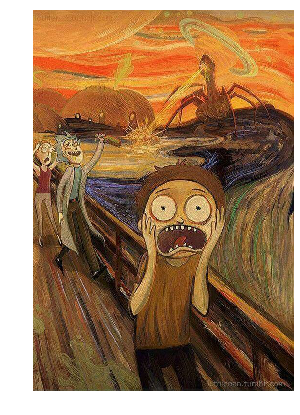

In [164]:
img = open_image('data/the_scream.jpg')
img.show(figsize=(5, 7))

In [165]:
pred = learner.predict(img)
print_pred_probs(pred, 3)

Surrealism: 54.74%
Art Nouveau (Modern): 20.90%
Expressionism: 12.50%


El resultado de nuestro clasificador fue bastante claro.

Pero nosotros sabemos que el cuadro original de Munch pertenece al Expresionismo. ¿Qué tal si recortamos la imagen para dejar fuera el bicho enorme de arriba?

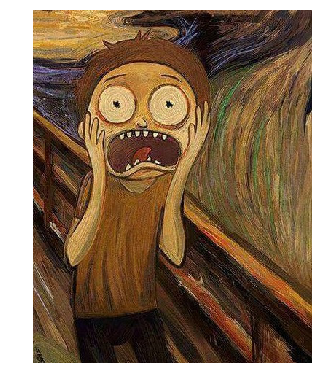

In [166]:
img = open_image('data/the_scream_crop.jpg')
img.show(figsize=(5, 7))

In [167]:
pred = learner.predict(img)
print_pred_probs(pred, 3)

Expressionism: 58.67%
Surrealism: 18.87%
Art Nouveau (Modern): 10.71%


El recorte es clasificado dentro del Expresionismo, con más confianza incluso que en la anterior decisión. Bueno... en realidad se parece demasiado a la obra original, así que no es de extrañar este resultado.

¿Y por qué no probar con uno de mis cuadros? Voy a escoger el único del que tengo una foto a mano (copia de otro):

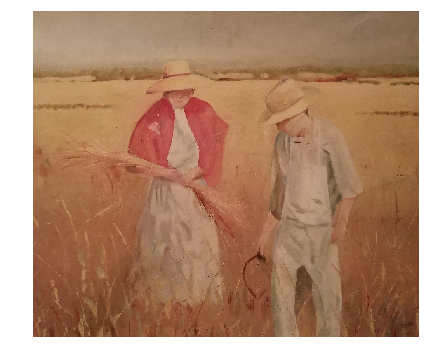

In [168]:
img = open_image('data/mine.png')
img.show(figsize=(8,6))

In [169]:
pred = learner.predict(img)
print_pred_probs(pred, 3)

Expressionism: 20.03%
Magic Realism: 17.40%
Abstract Expressionism: 9.84%


En mi humilde opinión este cuadro no encaja mucho dentro del Expresionismo. Además el clasificador tiene sus dudas entre 2 estilos, con poca confianza en la decisión. Quizá soy un artista demasiado ecléctico xD xD